# %% [markdown]
# # CNS MPO Score Calculation with pKa Integration via pkasolver
#
# This notebook calculates the CNS MPO score of compounds based on various properties computed from SMILES strings.
# In addition to RDKit-derived descriptors, we now predict the basic pKa using the open-source **pkasolver** tool.
# This allows more accurate CNS MPO scoring compared to using a fixed placeholder value.

# %%

In [1]:
# Importing necessary libraries
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import contextlib
import io
import logging
import math
from pkasolver.query import QueryModel
from pkasolver.ml_architecture import GINPairV1
import pickle 
import pkasolver
import torch
from os import path
from pkasolver.query import calculate_microstate_pka_values, draw_pka_reactions
from IPython.display import display
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - unable to change molecule rendering


In [3]:
# Initialize the pKa prediction model. The first run may download pre-trained model weights.
pka_model = QueryModel()
print("pkasolver is installed and working!")

pkasolver is installed and working!


In [4]:
# Load SMILES data from the file
file_path = '../Data/SMILES/SMILES_all_clean.txt'  # Adjust file path relative to notebook

def load_smiles(file_path):
    compounds = []
    with open(file_path, 'r') as f:
        for line in f:
            smi, name = line.strip().split('\t')
            compounds.append((name, smi))
    # Create a DataFrame with the desired column names:
    return pd.DataFrame(compounds, columns=["compound", "SMILES"])


# Read the SMILES data and calculate CNS-MPO scores
compounds = load_smiles(file_path)

[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1O[C@H]1CCOC1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been dep

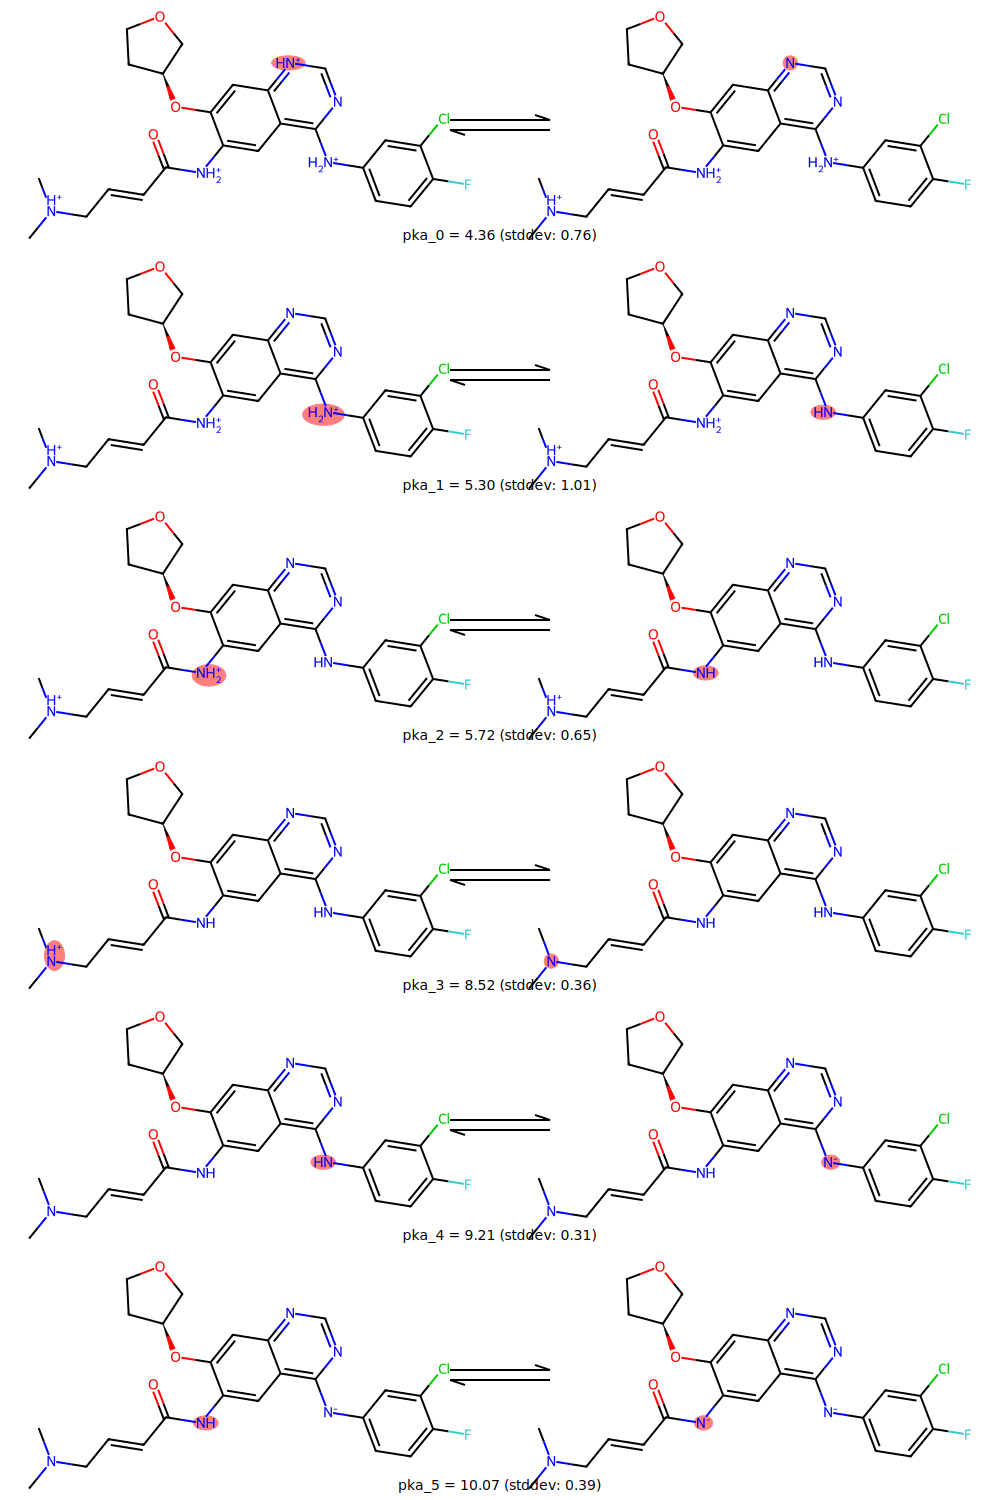

In [5]:
base_path = path.dirname(pkasolver.__file__)
smiles_test = compounds["SMILES"][0]
mol = Chem.MolFromSmiles(smiles_test)
protonation_states = calculate_microstate_pka_values(mol, only_dimorphite=False)
calc = draw_pka_reactions(protonation_states)
display(calc)

In [6]:
def get_basic_pka(smi, pka_model=None):
    """
    Predict the basic pKa of a compound using pkasolver.
    
    Parameters:
      smi (str): The SMILES string of the compound.
      pka_model: Unused placeholder for compatibility.
      
    Returns:
      float or None: The highest predicted pKa value among all ionization events,
                     interpreted as the basic pKa, or None if no prediction is available.
    """
    try:
        # Convert the SMILES to an RDKit molecule.
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            return None
        

        protonation_states = calculate_microstate_pka_values(mol, only_dimorphite=False)
        
        # For CNS-MPO, we assume that the highest predicted pKa is most relevant for basic compounds.
        if protonation_states:
            # Use the key parameter to compare by the numeric pka attribute.
            highest_state = max(protonation_states, key=lambda state: state.pka)
            return highest_state.pka  # Return the highest pKa value.
        else:
            return None
    except Exception as e:
        print(f"Error predicting pKa for {smi}: {e}")
        return None


In [7]:
def calculate_logD(clogP, pKa, pH=7.4):
    """
    Calculate the distribution coefficient (logD) at the specified pH for a basic compound.
    Uses the Henderson–Hasselbalch relationship for a monoprotic base:
    
        logD = clogP - log10(1 + 10^(pKa - pH))
    
    Parameters:
      clogP (float): Calculated log partition coefficient.
      pKa (float): Predicted basic pKa.
      pH (float): pH at which to compute logD (default is 7.4).
      
    Returns:
      float: Estimated logD.
    """
    # Ensure pKa is provided (if None, logD cannot be calculated)
    if pKa is None:
        return None
    return clogP - math.log10(1 + 10**(pKa - pH))

In [8]:
def compute_descriptors(smi, pka_model=None):
    """
    Compute chemical descriptors using RDKit and predict the basic pKa using pkasolver.
    
    Parameters:
      smi (str): SMILES string of the compound.
      pka_model: Unused placeholder for compatibility.
      
    Returns:
      dict or None: A dictionary with computed properties:
            - MW (Molecular Weight)
            - TPSA (Topological Polar Surface Area)
            - HBD (Number of Hydrogen Bond Donors)
            - clogP (Calculated LogP)
            - Basic_pKa (Predicted basic pKa)
                     or None if the molecule conversion fails.
    """
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None

    # Compute standard descriptors using RDKit.
    mw = Descriptors.MolWt(mol)
    tpsa = Descriptors.TPSA(mol)
    hbd = Descriptors.NumHDonors(mol)
    clogp = Descriptors.MolLogP(mol)
    
    # Predict the basic pKa using our get_basic_pka() function.
    basic_pka = get_basic_pka(smi, pka_model)

    # Calculate logD using the calculated clogP and predicted basic pKa.
    clogd = calculate_logD(clogp, basic_pka, pH=7.4) if basic_pka is not None else None
    
    return {'MW': mw, 'TPSA': tpsa, 'HBD': hbd, 'clogP': clogp, 'Basic_pKa': basic_pka, 'clogD': clogd}

In [9]:
def monotonic_decreasing(value, ideal, cutoff):
    """
    Piecewise linear transformation for a monotonic-decreasing parameter.
    
    Returns 1.0 if value <= ideal, 0.0 if value >= cutoff, and linearly interpolates
    for values in between.
    """
    if value <= ideal:
        return 1.0
    elif value >= cutoff:
        return 0.0
    else:
        return (cutoff - value) / (cutoff - ideal)

In [10]:
def hump_function_TPSA(value, lower_cutoff, lower_ideal, upper_ideal, upper_cutoff):
    """
    Piecewise linear hump transformation for TPSA.
    
    Returns 0.0 if value <= lower_cutoff or value >= upper_cutoff.
    Returns 1.0 if lower_ideal <= value <= upper_ideal.
    Linearly interpolates for values between the cutoffs and ideals.
    """
    if value <= lower_cutoff or value >= upper_cutoff:
        return 0.0
    elif lower_ideal <= value <= upper_ideal:
        return 1.0
    elif value < lower_ideal:
        return (value - lower_cutoff) / (lower_ideal - lower_cutoff)
    else:  # value > upper_ideal
        return (upper_cutoff - value) / (upper_cutoff - upper_ideal)

In [11]:
def cns_mpo_score(clogP, clogD, mw, tpsa, hbd, basic_pKa):
    """
    Compute the CNS MPO score using six physicochemical properties with the following desired ranges:
      - clogP: Ideal ≤ 3, cutoff ≥ 5 (monotonic decreasing)
      - clogD: Ideal ≤ 2, cutoff ≥ 4 (monotonic decreasing)
      - MW: Ideal ≤ 360, cutoff ≥ 500 (monotonic decreasing)
      - TPSA: Hump function with lower cutoff 20, ideal 40, upper ideal 90, upper cutoff 120
      - HBD: Ideal ≤ 0.5, cutoff ≥ 3.5 (monotonic decreasing)
      - Basic pKa: Ideal ≤ 8, cutoff ≥ 10 (monotonic decreasing)
      
    Each property is converted to a desirability score (0–1) and the total is the sum (maximum = 6).
    """
    d_clogP = monotonic_decreasing(clogP, ideal=3.0, cutoff=5.0)
    d_clogD = monotonic_decreasing(clogD, ideal=2.0, cutoff=4.0)
    d_mw = monotonic_decreasing(mw, ideal=360, cutoff=500)
    d_tpsa = hump_function_TPSA(tpsa, lower_cutoff=20, lower_ideal=40, upper_ideal=90, upper_cutoff=120)
    d_hbd = monotonic_decreasing(hbd, ideal=0.5, cutoff=3.5)
    d_pKa = monotonic_decreasing(basic_pKa, ideal=8.0, cutoff=10.0) if basic_pKa is not None else 0
    return d_clogP + d_clogD + d_mw + d_tpsa + d_hbd + d_pKa

In [ ]:
compounds_desc = compounds.copy()

# Compute descriptors for each compound (including clogD) and unpack the results into columns.
compounds_desc[['MW', 'TPSA', 'HBD', 'clogP', 'Basic_pKa', 'clogD']] = compounds_desc['SMILES'] \
    .apply(lambda smi: pd.Series(compute_descriptors(smi, pka_model=None)))

# Compute the CNS MPO score using the six-property version.
compounds_desc['CNS_MPO'] = compounds_desc.apply(
    lambda row: cns_mpo_score(row['clogP'], row['clogD'], row['MW'], row['TPSA'], row['HBD'], row['Basic_pKa']),
    axis=1
)

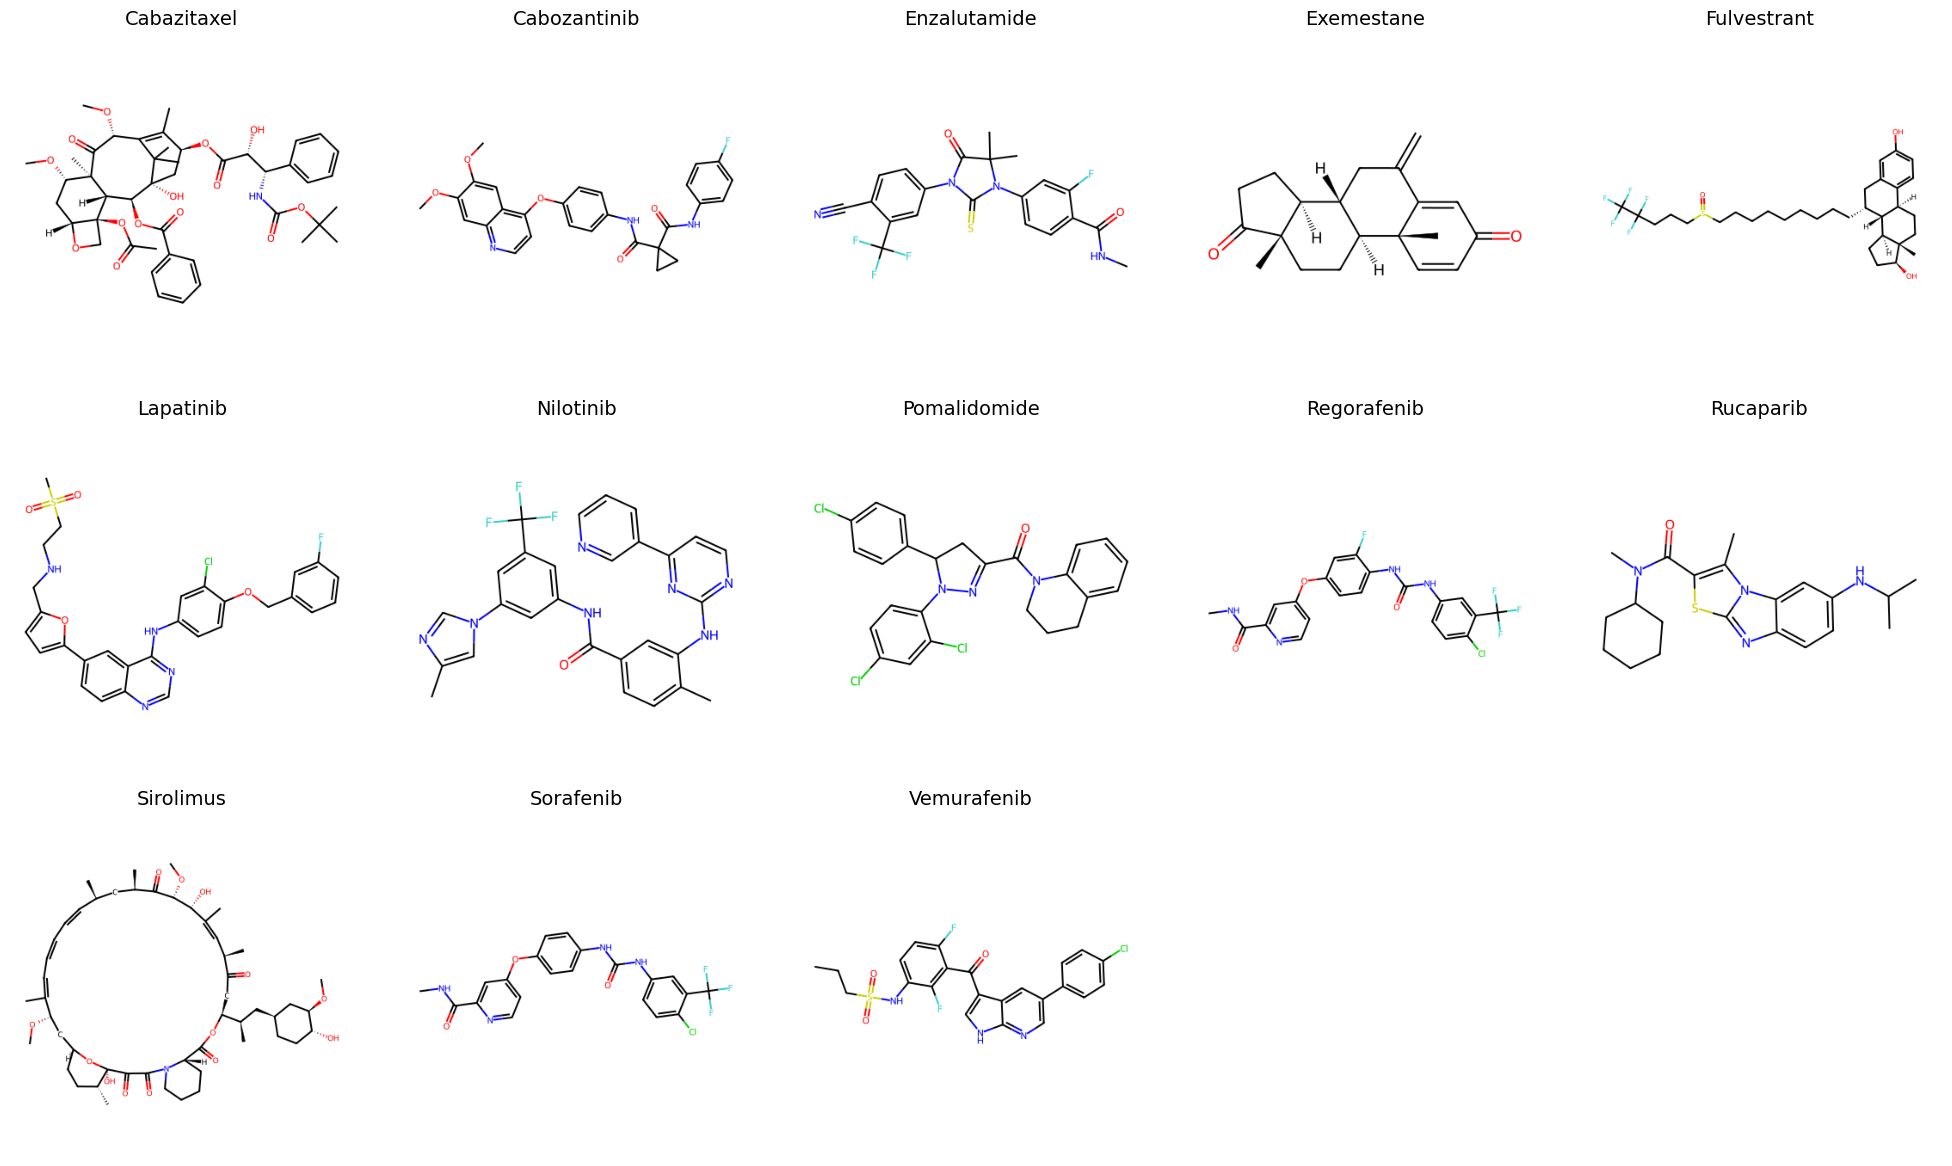

In [19]:
high_kp_compounds = [
    "Cabazitaxel", "Cabozantinib", "Enzalutamide", "Exemestane", 
    "Fulvestrant", "Lapatinib", "Nilotinib", "Pomalidomide", 
    "Regorafenib", "Rucaparib", "Sirolimus", "Sorafenib", "Vemurafenib"
]

# Filter the dataframe for the compounds in the list
filtered_df = compounds_desc[compounds_desc['compound'].isin(high_kp_compounds)]

# Parameters for layout
n_compounds = len(filtered_df)
n_rows = 3
n_columns = math.ceil(n_compounds / n_rows)

# Bigger molecule images and font
mol_size = (400, 400)  # adjust this for molecule image size
title_fontsize = 14

# Create the figure
fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns * 4, n_rows * 4))
axes = axes.flatten()

# Draw molecules
for i, (index, row) in enumerate(filtered_df.iterrows()):
    mol = Chem.MolFromSmiles(row['SMILES'])
    img = Draw.MolToImage(mol, size=mol_size)

    axes[i].imshow(img)
    axes[i].set_title(row['compound'], fontsize=title_fontsize)
    axes[i].axis('off')

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=2.0)  # less tight = more space between plots
plt.show()

In [13]:
# Export the DataFrame to a CSV file in your working directory
compounds_desc.to_csv('compounds_desc.csv', index=False)